# 製品プライサーは継続しました

その説明から、何かがどれだけの費用がかかるかを推定できるモデル。

## フロンティアを入力してください！

そして今 - 私たちはフロンティアモデルでテストする。

### ２つの重要なポイント：

フロンティアモデルをトレーニングしていないことを理解することが重要です。テストデータセットを提供して、どのように機能するかを確認しています。フロンティアモデルは、MLモデルに提供した400,000のトレーニング例の恩恵を得ていません。

とはいえ…

大規模なトレーニングデータでによって、トレーニングとテストセットのすべての製品情報を既に学習している可能性があります。したがって、ここではトレーニングをテストする可能性があり、それが彼らに不公平な利点を与えます。それを念頭に置いてください。

In [1]:
# import

import os
import re
import random
import math
import json
import pickle

from dotenv import load_dotenv
from huggingface_hub import login

import numpy as np
from collections import Counter, defaultdict
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

from openai import OpenAI
#from anthropic import Anthropic

In [2]:
# .envファイルから環境変数をロード

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
#os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Hugging Faceにログイン

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [4]:
# もう1つのインポート - Item クラスに加え Tester
# Testerを別のパッケージに移動（day3で既出なのでtesting.pyにはコメント追加してません）

from items import Item
from testing import Tester

In [5]:
openai = OpenAI()
#claude = Anthropic()

In [6]:
# JupiterNotebookでmatplotlibを表示できるようにする。
%matplotlib inline

In [7]:
# すべてのデータを再度キュレーションすることを避けましょう！ピクルスファイルにロード：

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# フロンティアを見る前に

## 検討できるもう1つのモデルがあります
`ed-donner` による人力推定らしい。

In [8]:
# テストセットをCSVに書込

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [9]:
# 推定結果を記入したCSVを読込

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [10]:
# itemのindexから `ed-donner` が推定した値を返す
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $374.41 Error: $254.41 SLE: 1.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $80.00 Truth: $225.11 Error: $145.11 SLE: 1.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.00 Truth: $61.68 Error: $26.68 SLE: 0.31 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $350.00 Truth: $599.99 Error: $249.99 SLE: 0.29 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $75.00 Truth: $16.99 Error: $58.01 SLE: 2.08 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.00 Truth: $31.99 Error: $19.99 SLE: 0.87 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $115.00 Truth: $101.79 Error: $13.21 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $100.00 Truth: $289.00 Error: $189.00 SLE: 1.11 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $300.00 Truth: $635.86 Error: $335.86 SLE: 0.56 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $80.00 Truth: $65.99 Error: $14.01 SLE: 0.0

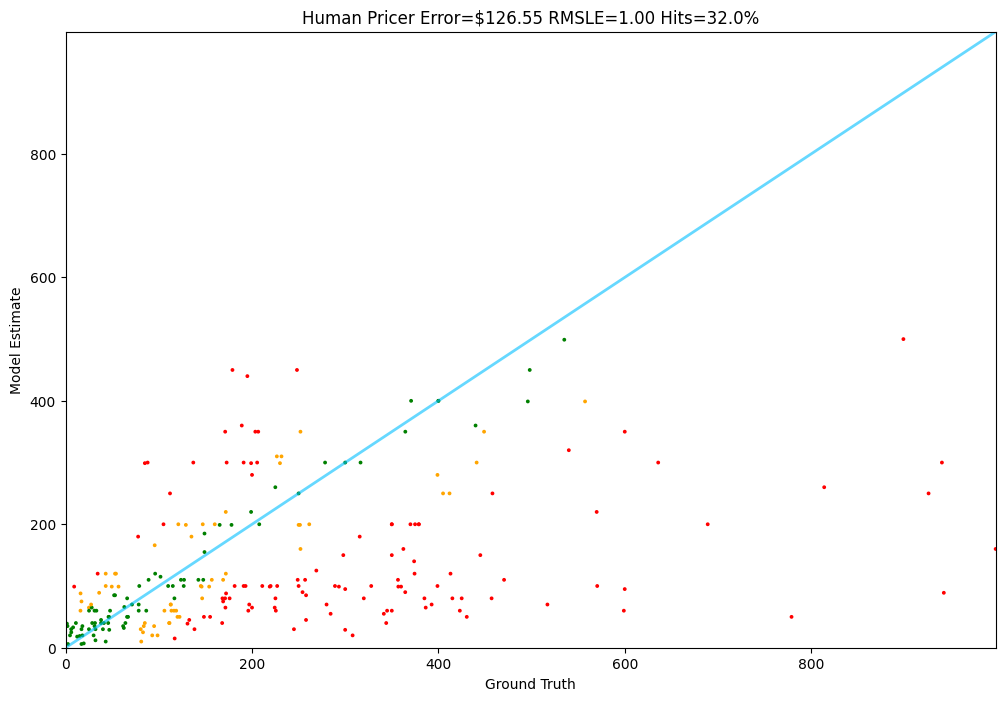

In [11]:
# TestRunnerを実行
Tester.test(human_pricer, test)

## まず、控えめながらもパワフルな gpt-4o-mini

ミニという名前ですが、実力は抜群です。

In [12]:
# まずは、フロンティアモデル向けに良いプロンプトを作ってみましょう。
# items.pyの中で設定した「1ドル単位で」(to the nearest dollar) という文言を取り除いていることに注目してください。
# "How much does this cost to the nearest dollar?" → "How much does this cost?"
# OSSのLLMをトレーニングする場合、問題を簡単にする必要があるが、フロンティアモデルには必要ない。
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [13]:
# プロンプト生成をテスト

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [14]:
# 文字列から価格を抽出する関数

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [15]:
# 価格抽出関数をテストする
get_price("The price is roughly $99.99 because blah blah")

99.99

In [16]:
# itemのプロンプトから gpt-4o-mini が推定した値を返す

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $260.00 Truth: $374.41 Error: $114.41 SLE: 0.13 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.99 Truth: $61.68 Error: $15.69 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.99 Truth: $599.99 Error: $200.00 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $29.99 Truth: $16.99 Error: $13.00 SLE: 0.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $49.99 Truth: $101.79 Error: $51.80 SLE: 0.49 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $599.00 Truth: $289.00 Error: $310.00 SLE: 0.53 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10

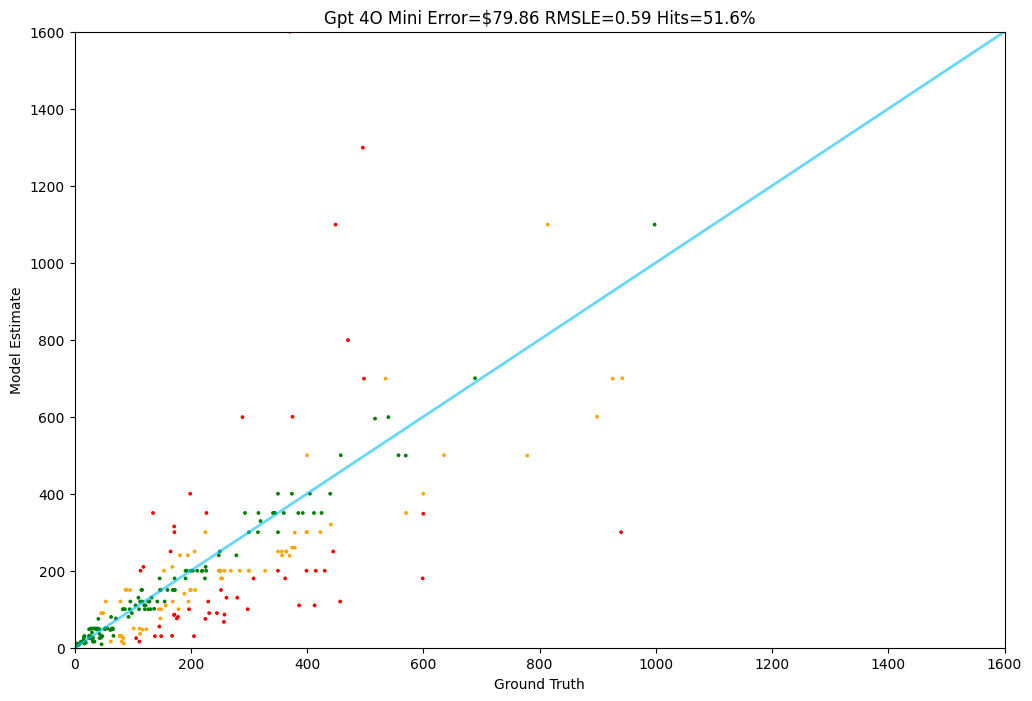

In [18]:
# TestRunnerを実行
Tester.test(gpt_4o_mini, test)

## gpt-4o 

In [19]:
# itemのプロンプトから gpt-4o が推定した値を返す

def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $280.00 Truth: $374.41 Error: $94.41 SLE: 0.08 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $30.47 Truth: $61.68 Error: $31.21 SLE: 0.47 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $450.00 Truth: $599.99 Error: $149.99 SLE: 0.08 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $23.99 Truth: $16.99 Error: $7.00 SLE: 0.11 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.00 Truth: $31.99 Error: $16.99 SLE: 0.52 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $110.47 Truth: $101.79 Error: $8.68 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $329.99 Truth: $289.00 Error: $40.99 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $500.00 Truth: $635.86 Error: $135.86 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10 It

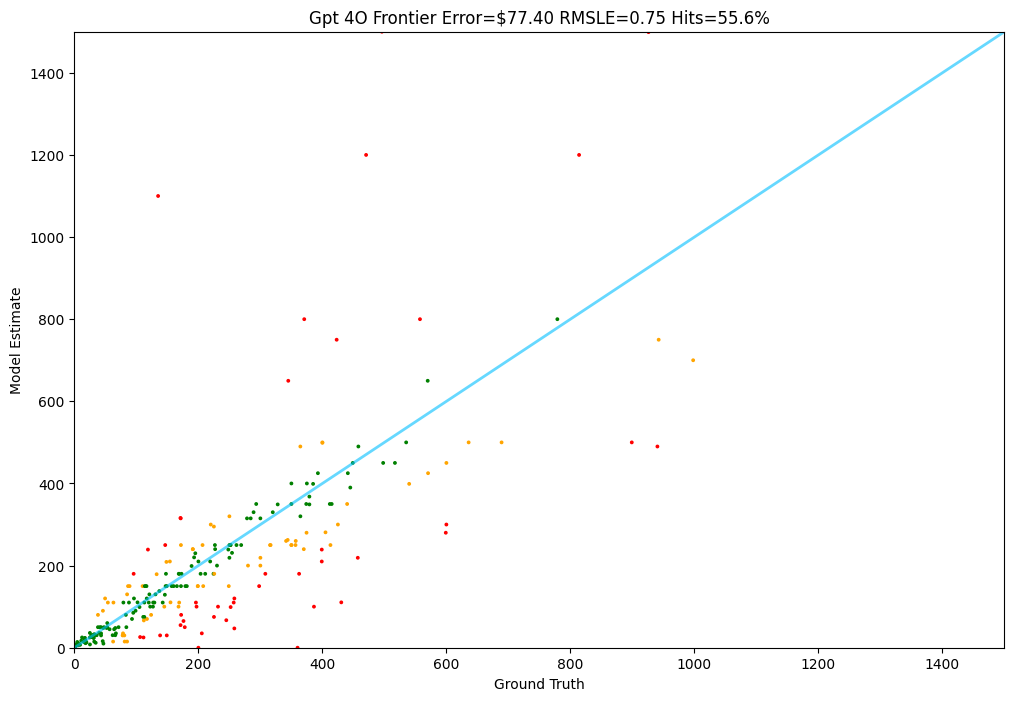

In [20]:
# TestRunnerを実行（約1〜2セントかかるので、スキップして代わりに `day4+results.ipynb` を見ることができます）
Tester.test(gpt_4o_frontier, test)

## claude-3-5-sonnet

```python
# itemのプロンプトから claude-3-5-sonnet が推定した値を返す

def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)
```

```python
# TestRunnerを実行（約1〜2セントかかるので、スキップして代わりに `day4+results.ipynb` を見ることができます）

Tester.test(claude_3_point_5_sonnet, test)
```